In [8]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [7]:
def nc_underest(new_lb, new_ub, v_list, model_list, add_node_num=0, n_samples=5, tolerance=1e-8):
    """
    Parameters:
        delta (float): range of variable
        n_samples (float): number of sample nodes
        v_list (list): list of scenario functions  
        model: model with submodels corresponds to each scenario
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    y_nodes = np.linspace(new_lb, new_ub, n_samples).tolist()
    lst = np.ones(N).tolist()
    y_opt_list = np.ones(N).tolist() 
    as_nodes_list = np.ones(N).tolist() 
    ms_list = np.ones(N).tolist() 
    eff_node_count = 0
    new_nodes_list = [None] * N
    
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-9
    solver.options['OptimalityTol'] = tolerance
    solver.options['NonConvex'] = 2 

        
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('start')
    for k in range(add_node_num+1):
        print('Adding node ',k)
        for i in range(N):
            print('Solving scenario ',i)
            # calculate interpolation points
            as_nodes_list[i] = [v_list[i](y) for y in y_nodes]
        
            # define piecewise function for each scenario
            if hasattr(model_list[i], 'As'):
                model_list[i].del_component('As')
            if hasattr(model_list[i], 'pw'):
                model_list[i].del_component('pw')
            if hasattr(model_list[i], 'obj'):
                model_list[i].del_component('obj')
            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            # set ip objective for each scenario and solve
            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            ms_list[i] = results.problem.lower_bound
            
            # check if new node is too close to old nodes         
            if (k > 0) and (abs(new_nodes_list[i] - value(model_list[i].y)) <= 1e-6):
                print("The new node is too close and not inserted")
                break
                
            # insert new nodes
            new_nodes_list[i] = value(model_list[i].y)
            if (new_nodes_list[i] not in y_nodes) and (k != add_node_num):
                bisect.insort(y_nodes, new_nodes_list[i])
                eff_node_count += 1

    # define and solve the sum model
    assum_nodes = np.sum(as_nodes_list, axis=0)
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("Sum model doesn't get solved normally")
    # get the output
    errors = results.problem.lower_bound + sum(ms_list)
    errors = -errors
    
    # calculate the diameter
    delta = (new_ub-new_lb)/2
    return delta, errors, y_nodes, as_nodes_list[0], ms_list[0],as_nodes_list[1], ms_list[1],eff_node_count

In [3]:
# build function for each scenario 
def v_1(y):  
    if y < 5 or y > 20:
        return float('inf')
    elif 5 <= y < 6.53:
        return 2.5 * y - 10 * (2 * y - 10)
    else:
        return 2.5 * y - 10 * 20 / y


def v_2(y): 
    if y < 2.22 or y > 20:
        return float('inf')
    elif 2.22 <= y < 3.49:
        return 2.5 * y - 20 * (4.5 * y - 10)
    else:
        return 2.5 * y - 20 * 20 / y

v_list = [v_1, v_2]

# set up parameters and solvers
n_samples = 5
add_node_num=5
ylb = 6
yub = 15
tolerance=1e-9

m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var(bounds=(0, None))        ##################################
m1.c1 = Constraint(expr= 2*m1.y-m1.x1>=10)
m1.c2 = Constraint(expr= m1.x1 * m1.y<=20)
#m1.c3 = Constraint(expr= 2*sqrt(m1.x1+5)*log(m1.x1+2) <= 35)
m1.obj_expr = Expression(expr=2.5*m1.y - 10*m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(ylb, yub))
m2.x2 = Var(bounds=(0, None))        ##################################
m2.c1 = Constraint(expr= 4.5*m2.y-m2.x2>=10)
m2.c2 = Constraint(expr= m2.x2 * m2.y<=20)
#m1.c3 = Constraint(expr= 2*sqrt(m1.x1+5)*log(m1.x1+2) <= 35)
m2.obj_expr = Expression(expr=2.5*m2.y - 20*m2.x2)

# Plot the figures and error

In [5]:
# make delta list
adds = np.arange(0, 15)
results = [nc_underest(ylb,yub,v_list,[m1,m2],a) for a in adds]

start
Adding node  0
Solving scenario  0
ERROR: Solver (gurobi) returned non-zero return code (1)
ERROR: Solver log: Traceback (most recent call last):
      File "<stdin>", line 5, in <module> File "D:\Anaconda\lib\site-
      packages\pyomo\solvers\plugins\solvers\GUROBI_RUN.py", line 62, in
      gurobi_run
        model = read(model_file)
                ^^^^^^^^^^^^^^^^
      File "src\\gurobipy\\gurobi.pxi", line 336, in gurobipy._core.read File
      "src\\gurobipy\\gurobi.pxi", line 116, in gurobipy._core.gurobi.read
      File "src\\gurobipy\\gurobi.pxi", line 60, in
      gurobipy._core.gurobi._getdefaultenv File "src\\gurobipy\\env.pxi", line
      108, in gurobipy._core.Env.__init__
    gurobipy._exception.GurobiError: No Gurobi license found (user pc, host
    DESKTOP-PPPCF27, hostid 3ef6820a, cores 10)


ApplicationError: Solver (gurobi) did not exit normally

In [6]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][-3])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][-2]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    print('effective add node num ',results[i][-1])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",results[i][4])
    print("y_opt value is ",results[i][5])

    # make the plot
    plt.figure(figsize=(8, 5))
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {i:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

NameError: name 'results' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


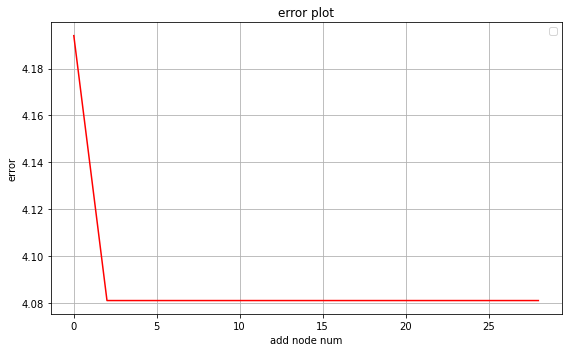

In [9]:
plt.figure(figsize=(8, 5))
errors = [item[1] for item in results]
plt.plot(2*adds, np.log(errors), color='red')

plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()